# Kalman Filter Models
> Models that use Kalman filters that can be used for imputation

In [1]:
%load_ext autoreload
%autoreload 2

## Introduction

[TODO] add proper introduction here

The models uses a latent state variable $x$ that is modelled over time, to impute gaps in $y$

### Equations

The equations of the model are:

$$\begin{align} p(x_t | x_{t-1}) & = \mathcal{N}(x_t, Ax_{t-1}, Q) \\
p(y_t | x_t) & = \mathcal{N}(Hx_t, T) \end{align}$$

The Kalman filter has 3 steps:

- filter (updating the state at time t with observations till time t-1)
- update (update the state at time t using the observation at time t)
- smooth (update the state using the observations at time t+1)

In case of missing data the update step is skipped.

After smoothing the whole dataset the missing data ($y_t$) can be imputed from the state ($x_t$) using this formula:
$$p(y_t) = \mathcal{N}(Hx_x, R + HP^s_tH)$$

## Kalman Filter Model

general kalman filter model implemented used `pykalman`


In [2]:
#| hide
#| default_exp kalman.model

In [3]:
#| export
import pandas as pd
from fastcore.basics import store_attr
import numpy as np

import pykalman
from numpy.ma import MaskedArray
import numpy as np
from fastcore.meta import delegates
from fastcore.basics import patch
from typing import Collection
from collections import namedtuple
from meteo_imp.results import ImputationResult, _display_as_row, _plot_error_bar
import altair as alt

#### PyKalman

examples from [pykalman lib](https://pykalman.github.io)

In [4]:
kf = pykalman.KalmanFilter(transition_matrices = [[1, 1], [0, 1]], observation_matrices = [[0.1, 0.5], [-0.3, 0.0]])
measurements = np.asarray([[1,0], [0,0], [0,1]])
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)

In [5]:
kf.em(measurements)

In [6]:
smoothed_state_means

array([[-0.10923868,  0.0935127 ],
       [-0.23121289, -0.07957144],
       [-0.5533711 , -0.0415223 ]])

In [7]:
smoothed_state_covariances

array([[[ 0.83148067, -0.12300405],
        [-0.12300405,  0.53081415]],

       [[ 1.60960449,  0.01009906],
        [ 0.01009906,  0.80412661]],

       [[ 2.87663094,  0.45474213],
        [ 0.45474213,  1.27365905]]])

In [8]:
smoothed_state_covariances.shape

(3, 2, 2)

In [9]:
#| export
# this is just a duplicate of NormParam, but with a better name
ListNormal = namedtuple('ListNormal', ['mean', 'cov'])

support is not limited for models matrices that don't change over time

In [10]:
#| export
class KalmanModel():
    "Base Model for Kalman filter that wraps `pykalman.KalmanFilter`. Doesn't support parameters that change over time"
    _var_names = None
    @delegates(pykalman.KalmanFilter)
    def __init__(self,
                 data: MaskedArray, # numpy array of observations
                 **kwargs):
        self.data = data
        self.n_obs = data.shape[0]
        self.n_features = data.shape[1]
        
        self.model = pykalman.KalmanFilter(**kwargs)
    
    def fit(self, n_iter: int=5, em_vars=None, smooth=True):
        "fit parameters using EM and calc state using smoother"
        self.model.em(self.data, n_iter=n_iter, em_vars=em_vars)
        mean, cov = self.model.smooth(self.data) if smooth else self.model.filter(self.data)
        self.state = ListNormal(mean, cov)
        return self
    
    def _obs_from_state(self, state_mean, state_cov):
        mean = self.model.observation_matrices @ state_mean
        cov = self.model.observation_matrices @ state_cov @ self.model.observation_matrices.T + self.model.observation_covariance
        return mean, cov
    def predict(self,
                times: np.ndarray # times for predictions (indices of the training data)
               ):
        "Predicts observed varibles values at the given times"
        # predicting outside the training data is not supported (yet)
        assert times.max() < self.n_obs
        means = np.empty((times.shape[0], self.n_features,))
        covs = np.empty((times.shape[0], self.n_features, self.n_features,)) 
        for i, t in enumerate(times):
            mean, cov = self._obs_from_state(self.state.mean[t], self.state.cov[t])
            means[i] = mean
            covs[i] = cov
        return ListNormal(means, covs)
    
    @property
    def latent_names(self):
        return [f"z_{i}" for i in range(self.model.transition_matrices.shape[0])]
    
    @property
    def var_names(self):
        return self._var_names if self._var_names is not None else [f"x_{i}" for i in range(self.n_features)]
    
    @var_names.setter
    def var_names(self, var_names):
        self._var_names = var_names
    

In [11]:
X = np.hstack([np.arange(0,3.), np.arange(3., 0, -1)]).reshape(6, 1)

In [12]:
X

array([[0.],
       [1.],
       [2.],
       [3.],
       [2.],
       [1.]])

In [13]:
X.shape

(6, 1)

In [14]:
k = KalmanModel(X)

In [15]:
k.fit(10)

In [16]:
T = np.arange(0,X.shape[0])

In [17]:
T

array([0, 1, 2, 3, 4, 5])

In [18]:
k.predict(T)

ListNormal(mean=array([[0.21296793],
       [1.01950281],
       [1.98157689],
       [2.79672264],
       [1.99068721],
       [1.1103803 ]]), cov=array([[[0.12474143]],

       [[0.19659773]],

       [[0.19733477]],

       [[0.19734326]],

       [[0.19743451]],

       [[0.20632342]]]))

#### Get Info

In [19]:
#| export
def _array2df(x, row_names, col_names, row_var):
    df = pd.DataFrame(x, columns=col_names)
    if row_names is not None: df.insert(0, row_var, row_names)
    return df

In [20]:
#| export
@patch
def get_info(self: KalmanModel, var_names=None):
    out = {}
    if var_names is not None: self.var_names = var_names 
    # latent names can use the updated var_names name
    latent_names = self.latent_names
    out['A'] = _array2df(self.model.transition_matrices, latent_names, latent_names, 'latent')
    out['H'] = _array2df(self.model.observation_matrices, var_names, latent_names, 'variable')
    out['R'] = _array2df(self.model.observation_covariance, var_names, var_names, 'variable')
    out['Q'] = _array2df(self.model.transition_covariance, latent_names, latent_names, 'latent')
    return out

In [21]:
_display_as_row(k.get_info())

 shit numpy arrays...

In [22]:
#| export
def _shift_1d(a, shift):
    a = np.roll(a, shift, axis=0)
    if shift> 0: a[:shift, :] = np.nan
    else: a[shift:, :] = np.nan 
    
    return a

In [23]:
_shift_1d(np.stack([np.vstack([np.arange(1, 4.)*i]*2) for i in range(4)]),2)

array([[[nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 1.,  2.,  3.],
        [ 1.,  2.,  3.]]])

In [24]:
_shift_1d(np.vstack([np.arange(1, 4.)*i for i in range(4)]),-1)

array([[ 1.,  2.,  3.],
       [ 2.,  4.,  6.],
       [ 3.,  6.,  9.],
       [nan, nan, nan]])

## Local Level Model

Local level models is a model that uses Kalman filter, where the design matrix (`A`) and the Transition matrix (`H`) are identity matrix. This means that the state of model is equal to the observations and the changes in the state are only from the process noise.


In [25]:
#| export
class LocalLevelModel(KalmanModel):
    "Local level model using a kalman filter"
    def __init__(self, data):
        transition_matrices = observation_matrices = np.eye(data.shape[1])
        # init with cov of transition of data
        transition_covariance = np.diag(np.nanvar(data - _shift_1d(data, -1), axis=0))
        em_vars = ['transition_covariance', 'observation_covariance']
        
        super().__init__(data, transition_matrices=transition_matrices, observation_matrices = observation_matrices, transition_covariance=transition_covariance, em_vars=em_vars )
        

In [26]:
ll = LocalLevelModel(X)

In [27]:
ll.fit()

In [28]:
ll.predict(np.array([5, 3]))

ListNormal(mean=array([[1.22847659],
       [2.59752825]]), cov=array([[[0.45973462]],

       [[0.42588627]]]))

In [29]:
ll2 = LocalLevelModel(np.hstack([X, X*2]))

In [30]:
ll2.fit()

In [31]:
ll2.predict(np.array([5, 3]))

ListNormal(mean=array([[1.10135575, 2.18600305],
       [2.81259028, 5.65372346]]), cov=array([[[0.25086027, 0.35069288],
        [0.35069288, 0.77948375]],

       [[0.23700609, 0.33877014],
        [0.33877014, 0.74905336]]]))

In [32]:
ll2.get_info()

{'A':   latent  z_0  z_1
 0    z_0  1.0  0.0
 1    z_1  0.0  1.0,
 'H':    z_0  z_1
 0  1.0  0.0
 1  0.0  1.0,
 'R':           0         1
 0  0.136841  0.181315
 1  0.181315  0.408279,
 'Q':   latent       z_0       z_1
 0    z_0  0.960236  1.852132
 1    z_1  1.852132  3.847645}

**Warning** this implementation of the EM algorithm may actually result in matrices that aren't correct for multivariate variables

## Local slope Model

Local slope models are an extentions of local level model that in the state variable keep track of also the slope

The transition matrix (`A`) is:

$$A = \left[\begin{array}{cc}1 & 1 \\ 0 & 1\end{array}\right]$$

the state $x \in \mathbb{R}^(2N) \times 1$ where the upper half keep track of the level and the lower half of the slope. $A \in \mathbb{R}^2N \times 2N$

hence the observation matrix (`H`) is:

$$A = \left[\begin{array}{cc}1 & 0 end{array}\right]$$

For the multivariate case the 1 are replaced with an identiy matrix


In [33]:
n_features = 2
Zero = np.zeros((n_features, n_features), dtype=np.float32)
I = np.eye(n_features)

A = np.vstack([np.hstack([I   , I]),
               np.hstack([Zero, I])])
H = np.hstack([I, Zero])

In [34]:
A.shape

(4, 4)

In [35]:
I.shape

(2, 2)

In [36]:
Zero.shape

(2, 2)

In [37]:
H.shape

(2, 4)

In [38]:
#| export
def _init_local_slope(n_features):
    Zero = np.zeros((n_features, n_features), dtype=np.float32)
    I = np.eye(n_features)

    A = np.vstack([np.hstack([I   , I]),
                   np.hstack([Zero, I])])
    H = np.hstack([I, Zero])
    return A, H

In [39]:
A, H = _init_local_slope(2)

In [40]:
#| export
class LocalSlopeModel(KalmanModel):
    "Local slope model using a kalman filter"
    # @classmethod
    def __init__(self, data):
        A, H = _init_local_slope(data.shape[1])
        em_vars = ['transition_covariance', 'observation_covariance']
        
        super().__init__(data, transition_matrices=A, observation_matrices = H, em_vars=em_vars )
    
    @property
    def latent_names(self):
        return [f"level_{var}" for var in self.var_names] + [f"slope_{var}" for var in self.var_names] 

In [41]:
ls = LocalSlopeModel(X)

In [42]:
ls.model

In [43]:
ls.fit()

In [44]:
ls.predict(np.array([3, 2]))

ListNormal(mean=array([[2.716141  ],
       [2.01802129]]), cov=array([[[0.32816569]],

       [[0.32739003]]]))

In [45]:
X = np.array([[1, 2],
              [2, 3],
              [4, 5],
              [6, 7]])

In [46]:
X.shape

(4, 2)

In [47]:
(A @ X).shape

(4, 2)

In [48]:
H.shape

(2, 4)

In [49]:
H @ X

array([[1., 2.],
       [2., 3.]])

In [50]:
ls2 = LocalSlopeModel(np.hstack([X, X*2]))

In [51]:
ls2.fit()

In [52]:
ls2.predict(np.array([1, 2]))

ListNormal(mean=array([[1.76475393, 2.53536399, 3.52950785, 5.07072797],
       [3.88624563, 4.80683778, 7.77249127, 9.61367556]]), cov=array([[[0.62753041, 0.7826417 , 0.83204436, 1.56528339],
        [0.7826417 , 1.707989  , 1.56528339, 2.99296154],
        [0.83204436, 1.56528339, 1.87559695, 3.13056678],
        [1.56528339, 2.99296154, 3.13056678, 6.19743131]],

       [[0.66321396, 0.84217581, 0.90182172, 1.68435163],
        [0.84217581, 1.81191923, 1.68435163, 3.19923227],
        [0.90182172, 1.68435163, 2.01594655, 3.36870325],
        [1.68435163, 3.19923227, 3.36870325, 6.61076763]]]))

In [53]:
_display_as_row(ls2.get_info())

### State

In [54]:
#| export
def _cov2std(x):
    "convert cov of array of covariances to array of stddev"
    return np.diagonal(np.sqrt(x), axis1=1, axis2=2)

In [55]:
#| export
@patch
def plot_state(self: KalmanModel, n_cols = 2, bind_interaction = True, properties={}):

    s_mean, s_cov = self.state
    s_std = _cov2std(s_cov)
    
    time = np.arange(self.n_obs)
    
    mean = _array2df(s_mean, time, self.latent_names, 'time').melt('time', value_name='mean')
    std = _array2df(s_std, time, self.latent_names, 'time').melt('time', value_name='std' )
    
    state = pd.merge(mean, std, on=['time', 'variable'])
    
    plot_list = [alt.hconcat() for _ in range(0, len(self.latent_names), n_cols)]
    selection_scale = alt.selection_interval(bind="scales", encodings=['x']) if bind_interaction else None
    for idx, variable in enumerate(self.latent_names):
        data = state[state.variable == variable]
        plot_list[idx // n_cols] |= _plot_error_bar(data,
                                                   variable,
                                                   y_label = variable,
                                                   sel = selection_scale, properties=properties)
    
    plot = alt.vconcat(*plot_list)
    
    return plot


In [56]:
import altair as alt
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

/tmp/ipykernel_72537/4282844104.py:4: RuntimeWarning: invalid value encountered in sqrt
  return np.diagonal(np.sqrt(x), axis1=1, axis2=2)
/home/simone/.local/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


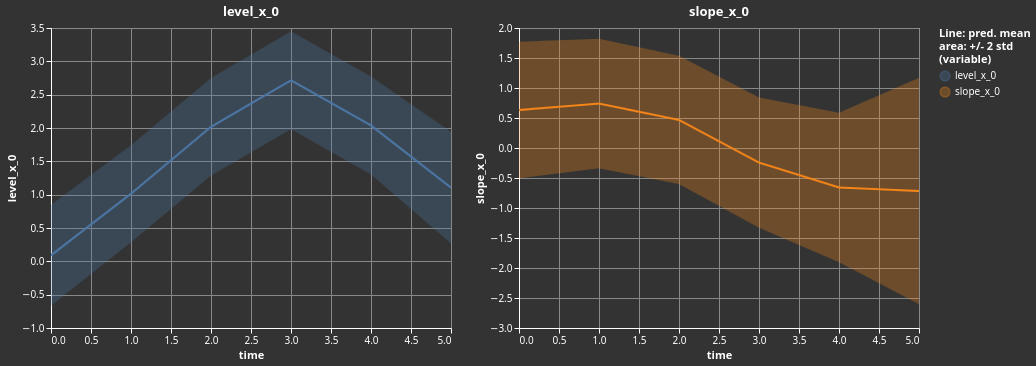

In [57]:
ls.plot_state()

## Export 

In [59]:
#| hide
from nbdev import nbdev_export
nbdev_export()